In [5]:
### EXERCISE 4.9
### Write a computer program to perform a quadratic discriminant
### analysis by fitting a separate Gaussian model per class. Try it out on the
### vowel data, and compute the misclassification error for the test data.

### Setup 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal as GaussianRV
from numpy.random import uniform
import math
import pandas as pd

In [7]:
### Read training dataset
training_set=pd.read_csv("vowel-training_set.csv").drop(columns='row.names')
N=len(training_set.drop(columns=['y']).keys())
K=len(training_set['y'].unique())
print("K={}".format(K))
print("N={}".format(N))
print(training_set.head()) 
print(training_set.dtypes)

K=11
N=10
   y    x.1    x.2    x.3    x.4    x.5    x.6    x.7    x.8    x.9   x.10
0  1 -3.639  0.418 -0.670  1.779 -0.168  1.627 -0.388  0.529 -0.874 -0.814
1  2 -3.327  0.496 -0.694  1.365 -0.265  1.933 -0.363  0.510 -0.621 -0.488
2  3 -2.120  0.894 -1.576  0.147 -0.707  1.559 -0.579  0.676 -0.809 -0.049
3  4 -2.287  1.809 -1.498  1.012 -1.053  1.060 -0.567  0.235 -0.091 -0.795
4  5 -2.598  1.938 -0.846  1.062 -1.633  0.764  0.394 -0.150  0.277 -0.396
y         int64
x.1     float64
x.2     float64
x.3     float64
x.4     float64
x.5     float64
x.6     float64
x.7     float64
x.8     float64
x.9     float64
x.10    float64
dtype: object


In [8]:
### Fit separate Gaussians for each class 
# calculate class means
means=training_set.copy().groupby(by='y').mean().reset_index()
# calculate class cov matrix
sigma=training_set.copy().groupby(by='y').cov()
sigma_inverse=sigma.copy()
# calculate inverse and determinant of class covariance matrices 
detDB=pd.DataFrame(columns=['y','det'])
for cindx in np.arange(1,K+1):
    # slice out the covariance matrix
    cov_matrix=sigma.copy().loc[(cindx,slice(None))]
    # claculate determinant and inverse
    det=np.linalg.det(cov_matrix.to_numpy())
    inv=np.linalg.inv(cov_matrix.to_numpy())
    # save in DBs 
    detDB=pd.concat([detDB,pd.DataFrame({'y': [cindx], 'det': [det]})],sort=False)
    sigma_inverse.loc[(cindx,slice(None)
                      )]=pd.DataFrame(inv, columns=sigma.keys(), index=pd.MultiIndex.from_tuples([(cindx,el) for el in cov_matrix.index]))
detDB=detDB.sort_values(by='y').reset_index(drop=True)
# calculate prior probabs  
pik=training_set.copy()['y'].value_counts().reset_index().rename(columns={'y':'counts','index':'y'})
pik['N']=pik.assign(fakekey=1).groupby(by='fakekey')['counts'].sum().iloc[0]
pik['pi_k']=pik['counts'].div(pik['N'])
print(means.head()) ; print(sigma_inverse.head()); print(detDB.head()); print(pik.head())

   y       x.1       x.2       x.3       x.4       x.5       x.6       x.7  \
0  1 -3.359563  0.062937 -0.294062  1.203333  0.387479  1.221896  0.096375   
1  2 -2.708875  0.490604 -0.580229  0.813500  0.201938  1.063479 -0.190917   
2  3 -2.440250  0.774875 -0.798396  0.808667  0.042458  0.569250 -0.280062   
3  4 -2.226604  1.525833 -0.874437  0.422146 -0.371313  0.248354 -0.018958   
4  5 -2.756313  2.275958 -0.465729  0.225312 -1.036792  0.389792  0.236417   

        x.8       x.9      x.10  
0  0.037104 -0.624354 -0.161625  
1  0.373813 -0.515958  0.080604  
2  0.204958 -0.478271  0.181875  
3  0.107146 -0.326271 -0.053750  
4  0.424625 -0.200708 -0.280708  
              x.1        x.2        x.3        x.4        x.5        x.6  \
y                                                                          
1 x.1  112.545234  53.446980  81.308825  63.701099  30.394740  20.853743   
  x.2   53.446980  35.598352  38.573517  25.281134  16.001868  21.101397   
  x.3   81.308825  38.5

In [9]:
### Read test dataset
test_set=pd.read_csv("vowel-test_set.csv").drop(columns=['row.names'])
print(test_set.head())

   y    x.1    x.2    x.3    x.4    x.5    x.6    x.7    x.8    x.9   x.10
0  1 -1.149 -0.904 -1.988  0.739 -0.060  1.206  0.864  1.196 -0.300 -0.467
1  2 -2.613 -0.092 -0.540  0.484  0.389  1.741  0.198  0.257 -0.375 -0.604
2  3 -2.505  0.632 -0.593  0.304  0.496  0.824 -0.162  0.181 -0.363 -0.764
3  4 -1.768  1.769 -1.142 -0.739 -0.086  0.120 -0.230  0.217 -0.009 -0.279
4  5 -2.671  3.155 -0.514  0.133 -0.964  0.234 -0.071  1.192  0.254 -0.471


In [10]:
### Calculate QDA predictions 
def QDF(z):
    # calculate quadratic discriminant functions 
    qdas=[]
    for cindx in np.arange(1,K+1):
        m=means.loc[means.y==cindx].drop(columns=['y']).to_numpy().flatten()
        s=sigma_inverse.copy().loc[(cindx,slice(None))].to_numpy()
        d=float(detDB.loc[detDB.y==cindx,'det'])
        p=float(pik.loc[pik.y==cindx,'pi_k'])
        qt=-0.5*np.log(d)-0.5*np.matmul((z-m).T,np.matmul(s,z-m))+np.log(p)
        qdas.append(qt)
    return qdas

predictions=test_set.copy().drop(columns=['y']).groupby(by=None,axis=0,level=0).apply(lambda z: QDF(z.to_numpy().flatten()))
predictions=predictions.reset_index().rename(columns={0:'QDA_values'})
predictions['QDA_max']=predictions['QDA_values'].apply(lambda z: np.amax(z))
predictions['max_position']=predictions['QDA_values'].apply(lambda z: int(np.where(z==np.amax(z))[0]))
predictions['yhat']=predictions['max_position'].apply(lambda z: 1+z)
print(predictions)

     index                                         QDA_values    QDA_max  \
0        0  [-7.471428644483783, -55.015652157020334, -156...  -7.471429   
1        1  [-10.4700844680682, 7.149851287630272, -59.985...   7.149851   
2        2  [-48.066767548451686, -16.47612971350034, -11....  -6.497370   
3        3  [-106.81221146127704, -63.65862491514442, -53.... -20.880017   
4        4  [-77.21366988667799, -61.13696059035083, -194....   3.800325   
..     ...                                                ...        ...   
457    457  [-92.18859261158795, -94.1502463233152, -230.1...  -8.055364   
458    458  [-140.9736649277744, -192.92575137235838, -330... -24.297209   
459    459  [-55.747741647369686, -91.65076105540727, -111...   0.022585   
460    460  [-91.0476790872223, -85.24229389915574, -144.1... -25.048163   
461    461  [-57.88439925180882, -37.39790185079726, -83.5...  -5.056748   

     max_position  yhat  
0               0     1  
1               1     2  
2        

In [11]:
### Calculate misclassification error
summary=test_set.reset_index().merge(predictions[['index','yhat']],on='index',how='left')
summary['misclassification_error']=(summary['y']==summary['yhat']
                                          ).apply(lambda z: 0 if z==True else 1)
err=int(summary['misclassification_error'].sum())
print("misclassification error = {}".format(err/len(summary)))
print("accuracy = {}".format(1-err/len(summary)))

misclassification error = 0.5281385281385281
accuracy = 0.47186147186147187


In [12]:
### SAFETY CHECK 
### SKLEARN AUTOMATIC ALGO 

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

X, y=training_set.drop(columns=['y']).to_numpy(), training_set['y'].to_numpy()
Xtest, ytest=test_set.drop(columns=['y']).to_numpy(), test_set['y'].to_numpy()

model=QuadraticDiscriminantAnalysis(store_covariance=True)
model.fit(X,y)
print("model accuracy={}".format(model.score(Xtest,ytest)))

model accuracy=0.47186147186147187


In [13]:
# check class means 
print(np.array_equal(model.means_,means.drop(columns=['y']).to_numpy()))
# check class covariance matrices 
print(all([ np.array_equal(np.round(model.covariance_[indx],12),
                       np.round(sigma.loc[(1+indx,slice(None))].to_numpy(),12)) for indx in np.arange(0,K)]))
# check priors 
print(np.array_equal(model.priors_,pik.sort_values(by='y')['pi_k'].to_numpy()))
# check predictions 
print(np.array_equal(model.predict(Xtest),predictions['yhat'].to_numpy()))

True
True
True
True


In [14]:
### Compare with logistic regression
from sklearn.linear_model import LogisticRegression
lgrmodel=LogisticRegression(penalty='none',multi_class='multinomial',solver='lbfgs',max_iter=1000)
lgrmodel.fit(X,y)
print("model accuracy={}".format(lgrmodel.score(Xtest,ytest)))

model accuracy=0.487012987012987


In [77]:
### Reduced-rank LDA 

### Step 1. 
# calculate matrix of class centroids 
M=means.copy().drop(columns=['y']).to_numpy()
# calculate within-class covariance 
# within-class covariance is the pooled covariance about the means (for each class)
features_no=len(training_set)
W=np.zeros((N,N))
for l in np.arange(1,K+1):
    # sigma contains within-class covariance matrices for all classes 
    # we calculate W by summing them (after rescaling) 
    rcovmat=sigma.copy().loc[(l,slice(None))].to_numpy()*(int(pik.loc[pik.y==l,'counts'])-1)
    W=np.add(W,rcovmat)
W=W/(features_no-K)

### Step 2. 
# eigendecomposition of W 
d, U=np.linalg.eig(W)
z=[1./np.sqrt(z) for z in d]
Wsqr=np.matmul(np.diag(z),U.T)
Mstar=np.matmul(M,Wsqr)

### Step 3.
# calculate between-class covariance (weighted by the within-class covariance) 
# between-class covariance is the covariance of class centroids 
# take transpose because each centroid is an observation 
Bstar=np.cov(Mstar.T)
d, Vstar=np.linalg.eig(Bstar)

### Calculate discriminant variables 
v=np.matmul(Wsqr,Vstar)

### Project dataset and centroids over the subspaces 
X, y=training_set.drop(columns=['y']).to_numpy(), training_set['y'].to_numpy()
Z=np.matmul(X,v)
C=np.matmul(M,v)


Text(0, 0.5, 'Coordinate 9')

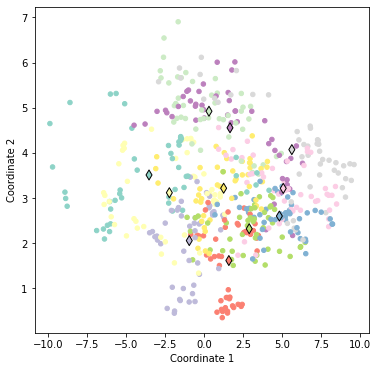

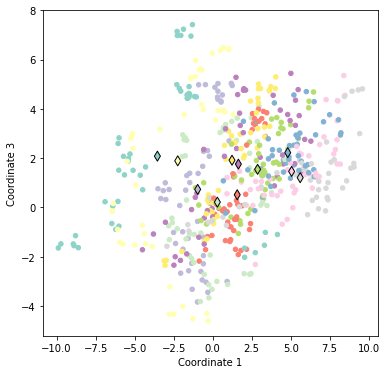

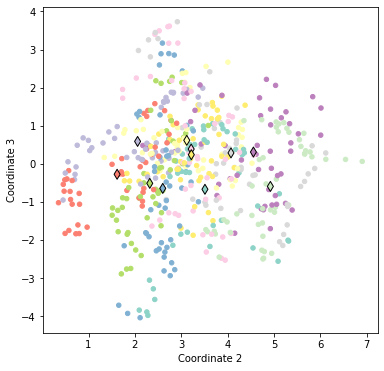

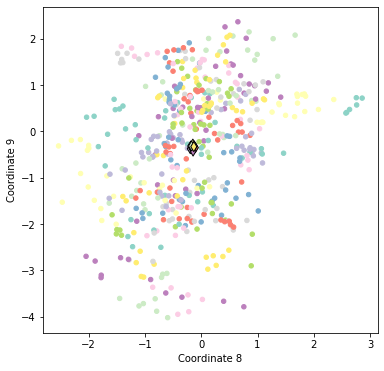

In [102]:
### Low dimensional representation of vowel data 

# cano coord 1 vs. cano coord 2
fig=plt.figure(figsize=(6., 6.))
plt.scatter(Z[:,0],Z[:,1],c=y,cmap="Set3",marker='o',s=20.)
plt.scatter(C[:,0],C[:,1],c=np.linspace(0,K,K),cmap="Set3",edgecolors='k',marker='d',s=50.)
plt.xlabel('Coordinate 1') ; plt.ylabel('Coordinate 2')

# cano coord 1 vs. cano coord 3
fig=plt.figure(figsize=(6., 6.))
plt.scatter(Z[:,0],Z[:,2],c=y,cmap="Set3",marker='o',s=20.)
plt.scatter(C[:,0],C[:,2],c=np.linspace(0,K,K),cmap="Set3",edgecolors='k',marker='d',s=50.)
plt.xlabel('Coordinate 1') ; plt.ylabel('Coordinate 3')

# cano coord 1 vs. cano coord 2
fig=plt.figure(figsize=(6., 6.))
plt.scatter(Z[:,1],Z[:,3],c=y,cmap="Set3",marker='o',s=20.)
plt.scatter(C[:,1],C[:,3],c=np.linspace(0,K,K),cmap="Set3",edgecolors='k',marker='d',s=50.)
plt.xlabel('Coordinate 2') ; plt.ylabel('Coordinate 3')

# cano coord 9 vs. cano coord 10
fig=plt.figure(figsize=(6., 6.))
plt.scatter(Z[:,8],Z[:,9],c=y,cmap="Set3",marker='o',s=20.)
plt.scatter(C[:,8],C[:,9],c=np.linspace(0,K,K),cmap="Set3",edgecolors='k',marker='d',s=50.)
plt.xlabel('Coordinate 8') ; plt.ylabel('Coordinate 9')